In [1]:
"""
@author: albertigno

"""

from DatasetLoader import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print ('Running on: {}'.format(device))

dataset = 'marshalling'
ds_method = dataset
dataset_path = r'./../../datasets'
thresh = 0.3

if dataset == 'shd':
    batch_size = 256 # default 256
    learning_rate = 1e-4 # default 1e-4
    time_window = 50 # shd 50, nmnist 25-30
    #time_window = 100
    train_path = dataset_path+'/shd_digits/shd_train.h5'
    test_path = dataset_path+'/shd_digits/shd_test.h5'
if dataset == 'marshalling':
    batch_size = 20 # default 256
    learning_rate = 1e-4 # default 1e-4
    time_window = 50 # shd 50, nmnist 25-30
    #time_window = 100
    train_path = dataset_path+'/marshalling/marshalling50_d5_train.mat'
    test_path = dataset_path+'/marshalling/marshalling50_d5_test.mat'  
    ds_method = 'nmnist'
else:
    batch_size = 200 
    learning_rate = 1e-4
    time_window = 25     
    train_path = dataset_path+'/nmnist/nmnist_train.mat'
    test_path = dataset_path+'/nmnist/nmnist_test.mat'           

Running on: cuda:0


In [12]:
%matplotlib notebook
from snn_models_monitor import *
%load_ext autoreload
%autoreload 1
%aimport snn_models_monitor

#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
#snn = RSNN_monitor('shd', num_hidden=512, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
#snn = RSNN_monitor('custom_2494_11', num_hidden=256, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn = RSNN_monitor('custom_3588_10', num_hidden=256, thresh=0.3, tau_m=tau_m, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RSNN_monitor(
  (fc_ih): Linear(in_features=3588, out_features=256, bias=False)
  (fc_hh): Linear(in_features=256, out_features=256, bias=False)
  (fc_ho): Linear(in_features=256, out_features=10, bias=False)
  (i_drop): Dropout(p=0.1, inplace=False)
)

<IPython.core.display.Javascript object>


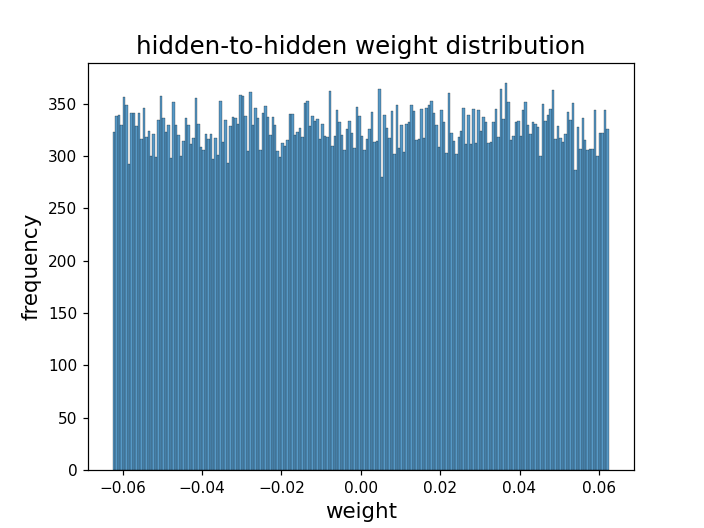

<AxesSubplot:title={'center':'hidden-to-hidden weight distribution'}, xlabel='weight', ylabel='frequency'>

In [13]:
snn.plot_weights('hh')

In [14]:
# load datasets
print("loading test set...")
test_dataset = DatasetLoader(test_path, ds_method, time_window, 'cpu')
print("loading training set...")
train_dataset = DatasetLoader(train_path, ds_method, time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 445
torch.Size([445, 50, 3588]) torch.Size([445, 10])
loading training set...
num sample: 1790
torch.Size([1790, 50, 3588]) torch.Size([1790, 10])
loading data with pytorch


[826.0, 186.7865168539326]


<IPython.core.display.Javascript object>


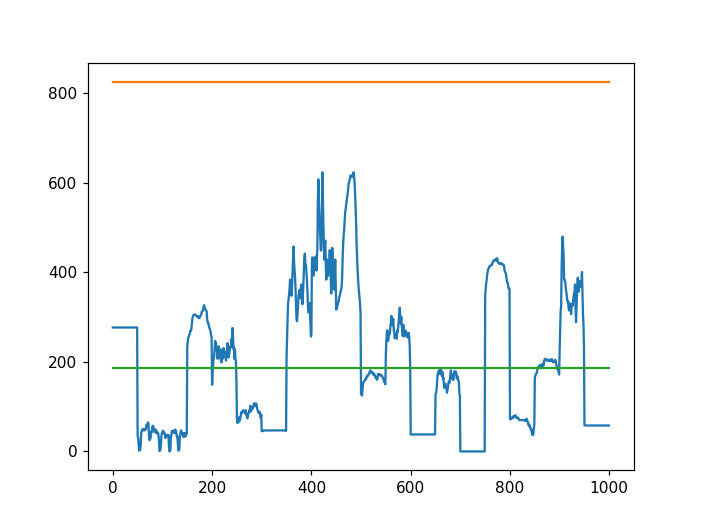

In [15]:
# check density of input spikes 
input_spike = test_dataset.images.reshape(-1, test_dataset.images.shape[-1]).sum(axis=1).cpu().numpy()
print([input_spike.max(), input_spike.mean()])
i_s = input_spike[:1000]
t = len(i_s)
plt.figure()
plt.plot(i_s)
plt.plot(np.arange(t), input_spike.max()*np.ones(t))
plt.plot(np.arange(t), input_spike.mean()*np.ones(t))
plt.show()

In [16]:
# training configuration

num_epochs = 20
modelname = dataset+'_rnn_{}.t7'.format(snn.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

#optimizer = torch.optim.Adam(snn.parameters(), lr=learning_rate)

# set different learning rates
base_params = [snn.fc_ih.weight,
               snn.fc_hh.weight,
               snn.fc_ho.weight, 
               ]
if tau_m=='adp':
    print('tau_m_h ')
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

marshalling_rnn_256.t7


In [17]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples, spkreg=0.1)
    print('Time elasped:', time.time() - start_time)
    
    # update learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if (epoch + 1) % 5 == 0:
        snn.test(test_loader, criterion=nn.MSELoss())
        #snn.save_model(modelname)   

Epoch [1/20]
Step [29/89], Loss: 2.47596
Step [58/89], Loss: 1.84900
Step [87/89], Loss: 1.49176
Time elasped: 7.40394401550293
Epoch [2/20]
Step [29/89], Loss: 1.14440
Step [58/89], Loss: 1.09993
Step [87/89], Loss: 1.04679
Time elasped: 7.532063245773315
Epoch [3/20]
Step [29/89], Loss: 0.89291
Step [58/89], Loss: 0.80345
Step [87/89], Loss: 0.80693
Time elasped: 7.378799200057983
Epoch [4/20]
Step [29/89], Loss: 0.73483
Step [58/89], Loss: 0.66683
Step [87/89], Loss: 0.66529
Time elasped: 7.668550491333008
Epoch [5/20]
Step [29/89], Loss: 0.61854
Step [58/89], Loss: 0.60110
Step [87/89], Loss: 0.55306
Time elasped: 7.698603391647339
avg spk_count per neuron for all 50 timesteps 2.917187213897705
Test Accuracy of the model on the test samples: 67.500
Epoch [6/20]
Step [29/89], Loss: 0.52654
Step [58/89], Loss: 0.51544
Step [87/89], Loss: 0.52606
Time elasped: 7.532588720321655
Epoch [7/20]
Step [29/89], Loss: 0.48455
Step [58/89], Loss: 0.45309
Step [87/89], Loss: 0.49584
Time elaspe

In [8]:
#snn.save_to_numpy(modelname[:-3])

In [18]:
snn.conf_matrix(test_loader)

[[67  1 13  0  0  2  0  2  0  0]
 [ 8 17  1  0  0  0  0  1  0  2]
 [ 7  0 17  0  6  0  0  0  0  0]
 [ 8  1  0 51  0  0  0  0  0  0]
 [12  0 15  0 12  0  0  1  0  0]
 [12  0  0  0  0 27  0  0  0  0]
 [20  1  0  1  0  2 36  0  0  0]
 [12  0  6  0  0  0  0 24  2  0]
 [ 1  0  0  0  0  0  0  0 23  0]
 [ 1  0  0  0  0  0  0  0  0 28]]


avg spk_count per neuron for all 50 timesteps 1.6408199071884155
Test Accuracy of the model on the test samples: 68.636


<IPython.core.display.Javascript object>


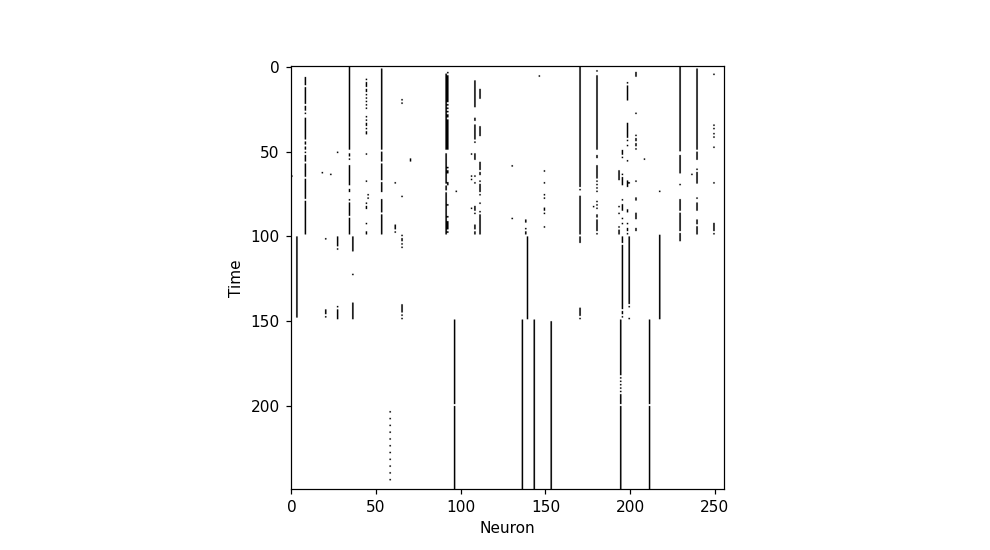

In [19]:
snn.test(test_loader, criterion=nn.MSELoss())
fig = snn.plot_activity('h','spike','normal', [0,1,2,3,4])

<IPython.core.display.Javascript object>


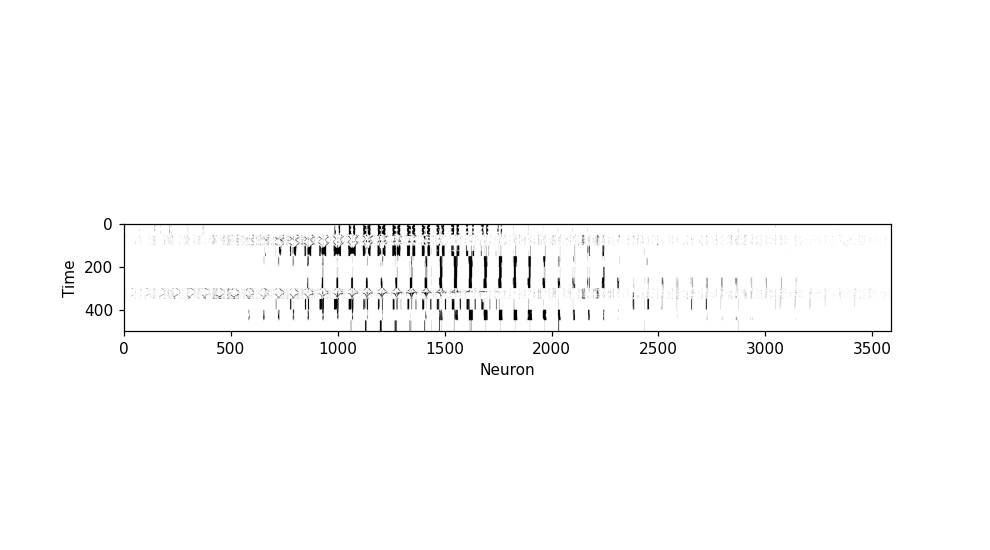

In [20]:
fig = snn.plot_activity('x','spike','normal', range(10))

[0, 1, 2]
[0, 1]
torch.Size([50, 20, 256])
torch.Size([3, 100])


<IPython.core.display.Javascript object>


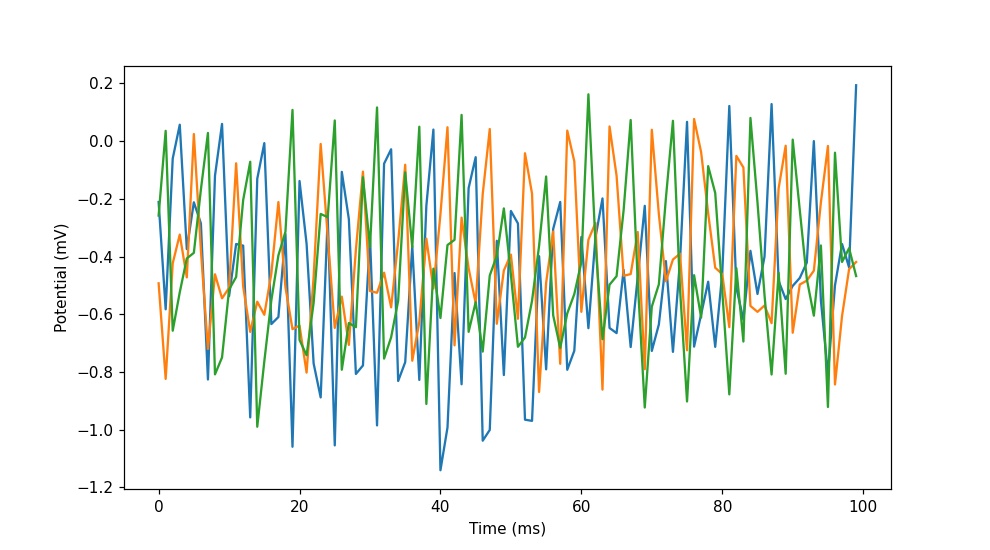

In [21]:
# neuron_id -> id of neurons to display
# sample_id -> id of sample to display
fig = snn.plot_mem('h', neuron_id =[0, 1, 2], sample_id = [0,1])

In [22]:
snn.test(test_loader, criterion=nn.MSELoss())

avg spk_count per neuron for all 50 timesteps 1.6408199071884155
Test Accuracy of the model on the test samples: 68.636


<IPython.core.display.Javascript object>


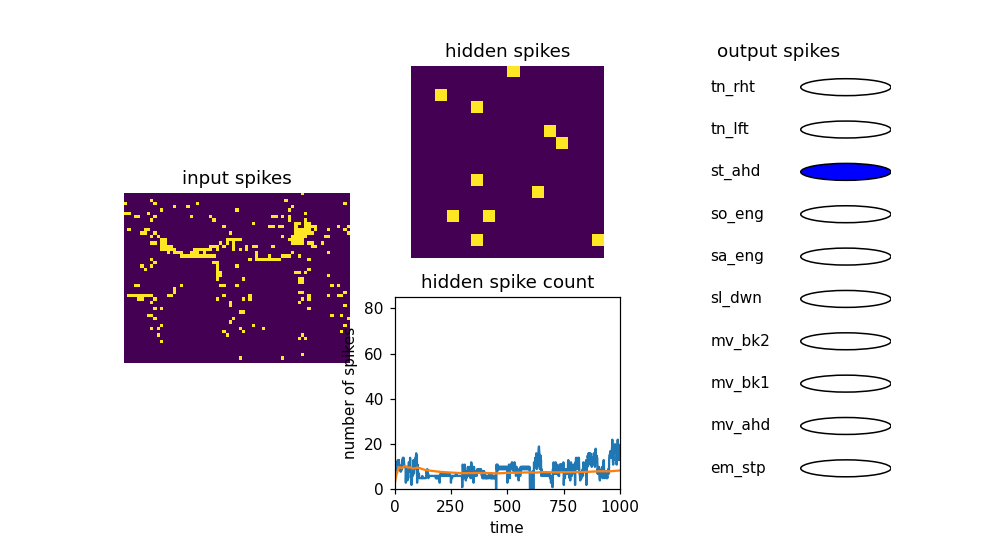

In [23]:
from matplotlib.animation import FuncAnimation
class_names = ['em_stp', 'mv_ahd', 'mv_bk1', 'mv_bk2', 'sl_dwn', 'sa_eng', 'so_eng', 'st_ahd', 'tn_lft', 'tn_rht']
anim = snn.animation(anim_frames = 1000, class_names= class_names)
plt.show()